In [1]:
import os
import json
from tqdm.auto import tqdm
import numpy as np
import tensorflow as tf
import utils

from waymo_open_dataset.protos import scenario_pb2

import matplotlib.pyplot as plt

from pykalman import KalmanFilter

np.random.seed(7)

# Step 1: Transform Data to Numpy Array (3 hours)

In [ ]:
FILENAME = "data/train/"

path_list = [] # lists all tfrecord files

for root, dirs, files in os.walk(os.path.abspath(FILENAME)):
    files.sort()
    for file in files:
        path_list.append(os.path.join(root, file))

In [5]:
object_type = 'vehicle'
object_type_id = None

if object_type == 'vehicle':
    object_type_id = 1
elif object_type == 'pedestrain': 
    object_type_id = 2
elif object_type == 'cyclist':
    object_type_id = 3
    
agt_save_path = 'data/' + object_type + '/agt_trajs_json/'
ego_save_path = 'data/ego_trajs_json/'
if not os.path.exists(agt_save_path):
    os.makedirs(agt_save_path)
if not os.path.exists(ego_save_path):
    os.makedirs(ego_save_path)

# function to unpack the recorded data
def process_Data(filename): 
    i_ego, i_agt = 0, 0

    dataset = tf.data.TFRecordDataset(filename)
    
    for data in dataset:
        ego_sub_data = {'filename': os.path.split(filename)[-1], 'scenario_id': None, 'timestamp': None, 'ego_traj': None}
        
        proto_string = data.numpy()
        proto = scenario_pb2.Scenario()
        proto.ParseFromString(proto_string)        

        ego_traj = np.array([[state.center_x, state.center_y,state.center_z, state.heading, state.velocity_x, state.velocity_y]for state in proto.tracks[proto.sdc_track_index].states]).astype(np.float32)
        
        ego_sub_data['scenario_id'] = proto.scenario_id
        ego_sub_data['timestamp'] = np.array(proto.timestamps_seconds).astype(np.float32)
        ego_sub_data['ego_traj'] = ego_traj

        
        with open(ego_save_path+ os.path.split(filename)[-1]+ '_' + str(i_ego).zfill(5)+ '.json', "w") as write_file:
            json.dump(ego_sub_data, write_file, cls=utils.NumpyEncoder)
        
        i_ego = i_ego + 1
        
        for track in proto.tracks_to_predict:
            if proto.tracks[track.track_index].object_type == object_type_id and track.track_index != proto.sdc_track_index: # agt should not be ego
                agt_sub_data = {'filename': os.path.split(filename)[-1], 'scenario_id': proto.scenario_id, 'timestamp': None, 'ego_traj': ego_traj, 'agt_traj': None}
                agt_traj = np.array([[state.center_x, state.center_y,state.center_z, state.heading, state.velocity_x, state.velocity_y] for state in proto.tracks[track.track_index].states]).astype(np.float32)
               
                agt_sub_data['timestamp'] = np.array(proto.timestamps_seconds).astype(np.float32)
                agt_sub_data['agt_traj'] = agt_traj
                
                with open(save_path + os.path.split(filename)[-1]+ '_' + str(i_ego).zfill(5) + '_' + str(i_agt).zfill(5)+ '.json', "w") as write_file:
                    json.dump(agt_sub_data, write_file, cls=utils.NumpyEncoder)
                i_agt = i_agt+1
            
    return  i_ego, i_agt

i_e, i_a = 0, 0
for k in tqdm(path_list):
    i_ego_sub, i_agt_sub = process_Data(k) 
    i_e = i_e + i_ego_sub
    i_a = i_a + i_agt_sub
print('finish')
print('number of ego trajs:', i_e, 'number of agt trajs:', i_a)

  0%|          | 0/150 [00:00<?, ?it/s]

finish
44097 161788


# Step 2: Preprocessing Ego Trajectories (Smoothing)

In [6]:
ego_path_list = []

for root, dirs, files in os.walk(os.path.abspath('data/ego_trajs_json/')):
    files.sort()
    for file in files:
        ego_path_list.append(os.path.join(root, file))

In [8]:
origin_num_points_in_traj = 91 # We have 91 sample points in one 9s trajectory
num_points_in_trajs = [91, 81, 71, 61, 51,41,31,21,11] # Target Number of points after splitting

for num_points_in_traj in num_points_in_trajs:
    print(num_points_in_traj)
    np.random.seed(7)
    posterior_means = np.zeros((len(path_list), num_points_in_traj, 6))
    posterior_a_lon = np.zeros((len(path_list), num_points_in_traj))

    outlier_idx_acc = []
    outlier_idx_time = []
    outlier_idx_pos = []
    outlier_idx_not_moving = []
    outlier_idx = []
    start_point_indicies = []
    
    
    # Initializing Kalman Smoother Parameters
    R = np.diag([0.005, 0.005, 0.1, 0.1]) # Observation Cov
    initial_state_mean = np.zeros(6)
    initial_state_covariance = np.diag(np.array([R[0, 0], R[2, 2], 10, R[1, 1], R[3, 3], 10]))

    dt = 0.1

    observation_matrix = np.array([[1, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 1, 0, 0],
                                   [0, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 1, 0]])

    Q = np.kron(np.eye(2), np.array([[(dt**5)/20, (dt**4)/8, (dt**3)/6],
                          [(dt**4)/8,  (dt**3)/3, (dt**2)/2],
                          [(dt**3)/6,  (dt**2)/2, dt]]).astype(np.float32)) # Process Cov
    
    parameter = {'R': np.diag(R), 'init_cov':np.diag(initial_state_covariance), 'q': 1}

    for idx, path in enumerate(tqdm(ego_path_list)):
        T, traj, start_point_idx = utils.extract_traj_data(file_path=path, target_num_of_points=num_points_in_traj , traj_type = 'ego_traj')
        start_point_indicies.append(start_point_idx)

        dT = T[1:] - T[:-1]

        transition_matrices = [np.kron(np.eye(2), np.array([[1, dt, 0.5* (dt**2)], 
                                                             [0, 1, dt],
                                                             [0, 0, 1]])) for dt in dT]

        initial_state_mean[1] = traj[0,2]
        initial_state_mean[4] = traj[0,3]


        kf = KalmanFilter(transition_matrices = transition_matrices, observation_matrices = observation_matrix, transition_covariance = Q,
                      observation_covariance = R, initial_state_mean = initial_state_mean, initial_state_covariance = initial_state_covariance)

        smoothed_state_means, smoothed_state_covariances  = kf.smooth(traj)

        v_xy = smoothed_state_means[:, [1, 4]]
        a_xy = smoothed_state_means[:, [2, 5]]
        
        # Calculate longitudinal acceleration based on velocity vector
        a_lon = np.array([np.dot(a ,v) / np.linalg.norm(v) for a, v in zip(a_xy.reshape(-1,2), v_xy.reshape(-1,2))])
        
        a_lon = a_lon.reshape(-1, num_points_in_traj)

        posterior_means[idx] = smoothed_state_means
        posterior_a_lon[idx] = a_lon
        
        # Find outlier with unfeasible acceleration and deceleration
        outlier_points_acc = np.argwhere((a_lon > 6) |(a_lon < -9.8))
        if outlier_points_acc.shape[0] > 0:
            outlier_idx_acc.append(idx)
        
        # Find outlier with high deviation between ks outout and measurement
        delta_pos_max = np.amax(np.linalg.norm(traj[:,[0,1]] - smoothed_state_means[:, [0,3]], axis=1))
        
        if delta_pos_max >2:
            outlier_idx_pos.append(idx)
            
        # Find not moving outlier    
        moving_d = np.linalg.norm(traj[-1, :2])
        
        if moving_d <= 0.5:
            outlier_idx_not_moving.append(idx)

        # Find outlier with time issue
        if (T[-1] >= ((num_points_in_traj-1) / 10) +0.5 ) | (T[-1] < ((num_points_in_traj-1) / 10) -0.5):
            outlier_idx_time.append(idx)



    outlier_idx = set(outlier_idx_acc) | set(outlier_idx_time) | set(outlier_idx_pos) | set(outlier_idx_not_moving)
    print('Find {0} outliers, from which {1} acc outlier, {2} time outlier, {3} pos outlier, {4} not moving'.format(len(outlier_idx), len(outlier_idx_acc), len(outlier_idx_time), len(outlier_idx_pos),len(outlier_idx_not_moving)))

    
    PATH = "data/ego_trajs_" + str(num_points_in_traj) + "_json"
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    with open(PATH + "/ego_trajs_outlier_indicies.json", "w") as write_file:
        json.dump(list(outlier_idx), write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/ego_trajs_outlier_indicies_pos.json", "w") as write_file:
        json.dump(list(outlier_idx_pos), write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/ego_trajs_outlier_indicies_acc.json", "w") as write_file:
        json.dump(outlier_idx_acc, write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/ego_trajs_outlier_indicies_time.json", "w") as write_file:
        json.dump(outlier_idx_time, write_file, cls=utils.NumpyEncoder)
        
    with open(PATH + "/ego_trajs_outlier_indicies_not_moving.json", "w") as write_file:
        json.dump(outlier_idx_not_moving, write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/ego_trajs_start_point_indicies.json", "w") as write_file:
        json.dump(start_point_indicies, write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/ego_trajs_filtered_CA.json", "w") as write_file:
        json.dump(posterior_means, write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/ego_trajs_filtered_a_lon.json", "w") as write_file:
        json.dump(posterior_a_lon, write_file, cls=utils.NumpyEncoder)
        
    with open(PATH + "/ks_parameter.json", "w") as write_file:
        json.dump(parameter, write_file, cls=utils.NumpyEncoder)

91


  0%|          | 0/487002 [00:00<?, ?it/s]

0 0 0 0


In [ ]:
idx = 406247
fig, ax = plt.subplots()
test_t, test_traj, _ = utils.extract_traj_data(file_path=ego_path_list[idx], origin_num_of_points=origin_num_points_in_traj, 
                                               traj_type='ego_traj', target_num_of_points=num_points_in_traj, start_idx=start_point_indicies[idx])
ax.plot(test_traj[:,0], test_traj[:,1], 'o', label = 'Measurement')
ax.plot(posterior_means[idx,:, 0], posterior_means[idx,:,3], 'o', fillstyle = 'none', label = 'KS Fitting')
ax.legend()

# (expired) Find not moving ego trajectories (expired)

In [6]:
path_list = []
num_points_in_traj = 51
for root, dirs, files in os.walk(os.path.abspath('data/ego_trajs_json/')):
    files.sort()
    for file in files:
        path_list.append(os.path.join(root, file))

In [8]:
with open("data/ego_trajs_" + str(num_points_in_traj) + "_json_new/ego_trajs_start_point_indicies.json", "r") as read_file:
    start_indicies = json.load(read_file)

In [9]:
def extract_data(file_path, start_point_idx):
    with open(file_path, "r") as read_file:
         data = json.load(read_file) 

    traj_xy = np.array(data['ego_traj'])[start_point_idx: start_point_idx+num_points_in_traj, :2] - np.array(data['ego_traj'])[start_point_idx, :2] # Let trajectory start from zero

    return traj_xy

In [10]:
not_moving_list = []

for idx, (path,s) in enumerate(tqdm(zip(path_list, start_indicies))):
    traj = extract_data(path,s)
    
    d = np.linalg.norm(traj[-1])
    if d <= 0.5:
        not_moving_list.append(idx)
        
len(not_moving_list)

0it [00:00, ?it/s]

123724

In [12]:
with open("data/ego_trajs_" + str(num_points_in_traj) + "_json_new/ego_trajs_outlier_indicies.json", "r") as read_file:
    outlier_idx = json.load(read_file)

In [14]:
len(set(outlier_idx) | set(not_moving_list))

123783

In [11]:
with open("data/ego_trajs_not_moving_indicies.json", "w") as write_file:
    json.dump(not_moving_list, write_file, cls=utils.NumpyEncoder)

# Preprocessing Agent Trajectories (Smoothing, 6 hours)

In [2]:
agt_file_path_list = []
np.random.seed(7)
object_type = 'vehicle'

select_file_idx = np.sort(np.random.choice(range(1829161), size=600000, replace=False)) # We randomly choose 60k data from all 1829161 agent trajectories (vehicle) for further processing

for root, dirs, files in os.walk(os.path.abspath('data/'+ object_type + '/agt_trajs_json/')):
    files.sort()
    for idx, file in enumerate(tqdm(files)):
        if '.json' not in file or 'checkpoint' in file: # ignore unrelated file
            continue
        
        # When processing vehicle trajs, we only choose 600000 for further processing, else we use all trajs.
        if idx in select_file_idx and object_type=='vehicle':
            agt_file_path_list.append(os.path.join(root, file))
        else:
            agt_file_path_list.append(os.path.join(root, file))

len(agt_file_path_list)

  0%|          | 0/1829161 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
len(agt_file_path_list)

231508

In [13]:
origin_num_points_in_traj = 91 # We have 91 sample points in one 9s trajectory
num_points_in_trajs = [91,81,71,61,51,41,31,21, 11] # Target Number of points after splitting

for num_points_in_traj in num_points_in_trajs:
    print(num_points_in_traj)
    np.random.seed(7)
    posterior_means = np.zeros((len(agt_file_path_list), num_points_in_traj, 6))
    posterior_a_lon = np.zeros((len(agt_file_path_list), num_points_in_traj))

    outlier_idx_acc = []
    outlier_idx_time = []
    outlier_idx_pos = []
    outlier_idx_not_moving = []
    outlier_idx = []
    start_point_indicies = []
    
    out_of_view = 0
    
    
    # Initializing Kalman Smoother Parameters
    R = np.diag([0.01, 0.01, 1, 1]) 

    initial_state_mean = np.zeros(6)
    initial_state_covariance = np.diag(np.array([R[0, 0], R[2, 2], 10, R[1, 1], R[3, 3], 10]))

    dt = 0.1

    observation_matrix = np.array([[1, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 1, 0, 0],
                                   [0, 1, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 1, 0]])
    
    Q = np.kron(np.eye(2), np.array([[(dt**5)/20, (dt**4)/8, (dt**3)/6],
                          [(dt**4)/8,  (dt**3)/3, (dt**2)/2],
                          [(dt**3)/6,  (dt**2)/2, dt]]).astype(np.float32)) # Process Cov
    
        
    parameter = {'R': np.diag(R), 'init_cov':np.diag(initial_state_covariance), 'q': 1}
    
    for idx, path in enumerate(tqdm(agt_file_path_list)):
        T, traj, start_point_idx = utils.extract_traj_data(file_path=path, target_num_of_points=num_points_in_traj , traj_type = 'agt_traj')
        
        # Activate this part for calculating out of view outliers
        # d_diff = traj[1:, :2] - traj[:-1, :2]
        # d_diff_norm = np.linalg.norm(d_diff, axis=1)
        # test = np.where(d_diff_norm >200)[0]
        # if test.size>0:
        #     out_of_view = out_of_view+1
        
        start_point_indicies.append(start_point_idx)

        dT = T[1:] - T[:-1]

        transition_matrices = [np.kron(np.eye(2), np.array([[1, dt, 0.5* (dt**2)], 
                                                             [0, 1, dt],
                                                             [0, 0, 1]])) for dt in dT]

        initial_state_mean[1] = traj[0,2]
        initial_state_mean[4] = traj[0,3]


        kf = KalmanFilter(transition_matrices = transition_matrices, observation_matrices = observation_matrix, transition_covariance = Q,
                      observation_covariance = R, initial_state_mean = initial_state_mean, initial_state_covariance = initial_state_covariance)

        smoothed_state_means, smoothed_state_covariances  = kf.smooth(traj)

        v_xy = smoothed_state_means[:, [1, 4]]
        a_xy = smoothed_state_means[:, [2, 5]]

        a_lon = np.array([np.dot(a ,v) / np.linalg.norm(v) for a, v in zip(a_xy.reshape(-1,2), v_xy.reshape(-1,2))])

        a_lon = a_lon.reshape(-1, num_points_in_traj)

        posterior_means[idx] = smoothed_state_means
        posterior_a_lon[idx] = a_lon

        delta_pos_max = np.amax(np.linalg.norm(traj[:,[0,1]] - smoothed_state_means[:, [0,3]], axis=1))
        
        moving_d = np.linalg.norm(traj[-1, :2])
        
        if delta_pos_max >2:
            outlier_idx_pos.append(idx)
            
        if moving_d <= 0.5:
            outlier_idx_not_moving.append(idx)

        if (T[-1] >= ((num_points_in_traj-1) / 10) +0.5 ) | (T[-1] < ((num_points_in_traj-1) / 10) -0.5):
            outlier_idx_time.append(idx)

        if object_type == 'vehicle':
            outlier_points_acc = np.argwhere((a_lon > 6) |(a_lon < -9.8))
        elif object_type == 'pedestrain':
            outlier_points_acc = np.argwhere((a_lon > 2) |(a_lon < -3))
        elif object_type == 'cyclist':
            outlier_points_acc = np.argwhere((a_lon > 2) |(a_lon < -4))
            
        if outlier_points_acc.shape[0] > 0:
            outlier_idx_acc.append(idx)

    outlier_idx = set(outlier_idx_acc) | set(outlier_idx_time) | set(outlier_idx_pos) | set(outlier_idx_not_moving)
    
    # we again choose 300000 trajs with outlier for our experiments
    if object_type == 'vehicle':
        non_outlier_idx = list(set(range(idx+1)) - outlier_idx)
        non_outlier_idx = np.sort(np.random.choice(non_outlier_idx, size=300000, replace=False))
    

    print('Find {0} outliers, from which {1} acc outlier, {2} time outlier, {3} pos outlier, {4} not moving'.format(len(outlier_idx), len(outlier_idx_acc), len(outlier_idx_time), len(outlier_idx_pos),len(outlier_idx_not_moving)))
    
    
    PATH = "data/"+ object_type + "/agt_trajs_" + str(num_points_in_traj) + "_json"
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    with open(PATH + "/agt_trajs_outlier_indicies.json", "w") as write_file:
        json.dump(list(outlier_idx), write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/agt_trajs_outlier_indicies_pos.json", "w") as write_file:
        json.dump(list(outlier_idx_pos), write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/agt_trajs_outlier_indicies_acc.json", "w") as write_file:
        json.dump(outlier_idx_acc, write_file, cls=utils.NumpyEncoder)

    with open(PATH + "/agt_trajs_outlier_indicies_time.json", "w") as write_file:
        json.dump(outlier_idx_time, write_file, cls=utils.NumpyEncoder)
        
    with open(PATH + "/agt_trajs_outlier_indicies_not_moving.json", "w") as write_file:
        json.dump(outlier_idx_not_moving, write_file, cls=utils.NumpyEncoder)
    
    if object_type == 'vehicle': # only store the 300000 selected data 
        with open(PATH + "/agt_trajs_select_non_outlier_indicies.json", "w") as write_file:
            json.dump(select_file_idx[non_outlier_idx], write_file, cls=utils.NumpyEncoder)

        with open(PATH + "/agt_trajs_start_point_indicies.json", "w") as write_file:
            json.dump(np.array(start_point_indicies)[non_outlier_idx], write_file, cls=utils.NumpyEncoder)

        with open(PATH + "/agt_trajs_filtered_CA.json", "w") as write_file:
            json.dump(posterior_means[non_outlier_idx], write_file, cls=utils.NumpyEncoder)
            
        with open(PATH + "/agt_trajs_filtered_a_lon.json", "w") as write_file:
            json.dump(posterior_a_lon[non_outlier_idx], write_file, cls=utils.NumpyEncoder)
    else: # store all data 
        with open(PATH + "/agt_trajs_start_point_indicies.json", "w") as write_file:
            json.dump(start_point_indicies, write_file, cls=utils.NumpyEncoder)

        with open(PATH + "/agt_trajs_filtered_CA.json", "w") as write_file:
            json.dump(posterior_means, write_file, cls=utils.NumpyEncoder)

        with open(PATH + "/agt_trajs_filtered_a_lon.json", "w") as write_file:
            json.dump(posterior_a_lon, write_file, cls=utils.NumpyEncoder)
        
    with open(PATH + "/ks_parameter.json", "w") as write_file:
        json.dump(parameter, write_file, cls=utils.NumpyEncoder)

91


  0%|          | 0/231508 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Find 114493 outliers, from which 114161 acc outlier, 154 time outlier, 113983 pos outlier, 6227 not moving
81


  0%|          | 0/231508 [00:00<?, ?it/s]

Find 102819 outliers, from which 102325 acc outlier, 129 time outlier, 102173 pos outlier, 2255 not moving
71


  0%|          | 0/231508 [00:00<?, ?it/s]

Find 94549 outliers, from which 93773 acc outlier, 89 time outlier, 93629 pos outlier, 2012 not moving
61


  0%|          | 0/231508 [00:00<?, ?it/s]

Find 85868 outliers, from which 84607 acc outlier, 54 time outlier, 84471 pos outlier, 2269 not moving
51


  0%|          | 0/231508 [00:00<?, ?it/s]

Find 76682 outliers, from which 74663 acc outlier, 39 time outlier, 74534 pos outlier, 3046 not moving
41


  0%|          | 0/231508 [00:00<?, ?it/s]

Find 67713 outliers, from which 64444 acc outlier, 24 time outlier, 64332 pos outlier, 4403 not moving
31


  0%|          | 0/231508 [00:00<?, ?it/s]

Find 58935 outliers, from which 53961 acc outlier, 19 time outlier, 53873 pos outlier, 6355 not moving
21


  0%|          | 0/231508 [00:00<?, ?it/s]

Find 50485 outliers, from which 41172 acc outlier, 9 time outlier, 41103 pos outlier, 10917 not moving
11


  0%|          | 0/231508 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
outlier_idx_pos[:100]

[15,
 16,
 21,
 31,
 32,
 42,
 50,
 57,
 72,
 79,
 86,
 104,
 111,
 128,
 133,
 143,
 144,
 151,
 194,
 211,
 228,
 251,
 254,
 272,
 276,
 296,
 299,
 304,
 306,
 307,
 314,
 318,
 322,
 324,
 327,
 333,
 342,
 343,
 344,
 357,
 408,
 415,
 426,
 452,
 453,
 455,
 462,
 467,
 471,
 475,
 481,
 487,
 501,
 507,
 512,
 535,
 538,
 539,
 544,
 546,
 563,
 585,
 590,
 607,
 609,
 620,
 621,
 623,
 627,
 641,
 643,
 647,
 648,
 649,
 655,
 668,
 670,
 671,
 687,
 697,
 699,
 702,
 711,
 715,
 719,
 726,
 740,
 760,
 765,
 769,
 774,
 782,
 792,
 794,
 799,
 800,
 803,
 811,
 812,
 817]

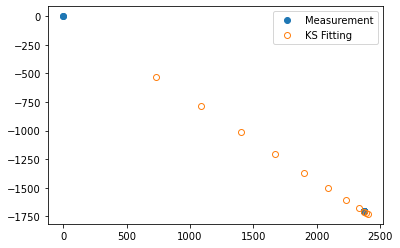

In [13]:
idx = 817
fig, ax = plt.subplots()
test_t, test_traj, _ = utils.extract_traj_data(file_path=agt_file_path_list[idx], origin_num_of_points=origin_num_points_in_traj, 
                                               traj_type='agt_traj', target_num_of_points=num_points_in_traj, start_idx=start_point_indicies[idx])
ax.plot(test_traj[:,0], test_traj[:,1], 'o', label = 'Measurement')
ax.plot(posterior_means[idx,:, 0], posterior_means[idx,:,3], 'o', fillstyle = 'none', label = 'KS Fitting')
ax.legend()